<a href="https://colab.research.google.com/github/rafavidal1709/doctor-yolo/blob/main/Doctor_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

URL do CloudRUN:

https://doctor-yolo-576668051133.us-central1.run.app/paciente%20C/80221442.dcm

# Login DB

In [2]:
from google.colab import userdata

DB_HOST="34.63.204.77"
DB_PORT="5432"
DB_NAME="doctor_yolo"
DB_USER="doctor_yolo"
DB_PASSWORD=userdata.get('doctor_yolo_key')
DB_SCHEMA="bbox"

from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError, ResourceClosedError

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    future=True
)
with engine.connect() as conn:
    conn.execute(text(f"SET search_path TO {DB_SCHEMA};"))
    rows = conn.execute(text('SELECT * FROM users LIMIT 10;')).all()
    for r in rows:
        print(r)

(1, 'Rafael Vidal', 'ucQQmvAQKNy0pClUWOpM5xog3HArQT5npo7-uvBlQXBY3g2xSLVHINQicrZSIGXu4oNxH5s7qqrMxLMNQ-Uxhg', None, datetime.datetime(2025, 10, 13, 15, 46, 0, 741588, tzinfo=datetime.timezone.utc), datetime.datetime(2025, 10, 13, 15, 46, 0, 741588, tzinfo=datetime.timezone.utc))
(2, 'Gustavo Scalabrini Sampaio', 'kVlbIMY1s3iE0QhqdZedhEVS7WM7ZPZLIJiMp0X23kvtQBm11VAr6oAjBzFXWMXlZq7gFQOoyC85aaE_NcTEmw', None, datetime.datetime(2025, 10, 16, 20, 47, 6, 373262, tzinfo=datetime.timezone.utc), datetime.datetime(2025, 10, 16, 20, 47, 6, 373262, tzinfo=datetime.timezone.utc))


In [ ]:
with engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    conn.execute(text(f"SET search_path TO {DB_SCHEMA};"))
    while True:
        print("Digite uma query:")
        query = input()
        if query.lower().strip() == "exit":
            break
        try:
            result = conn.execute(text(query))
            # Alguns comandos retornam linhas (SELECT, SHOW, etc.)
            if result.returns_rows:
                rows = result.fetchall()
                for r in rows:
                    print(r)
            else:
                print("✅ Comando executado com sucesso (sem retorno).")
                conn.commit()
        except ResourceClosedError:
            print("✅ Comando executado (sem retorno).")
        except Exception as e:
            print("❌ Erro:", e)
            conn.rollback()
        print('\n')


Digite uma query:
SELECT DISTINCT I.url, Y.user_id FROM yolo Y LEFT JOIN img I ON Y.img_id=I.id 
('paciente C/80221496', 1)
('paciente C/80221442.dcm', 1)
('paciente C/80221478', 1)
('paciente C/80221532', 1)
('paciente C/80221460', 1)
('paciente C/80221514', 1)


Digite uma query:
exit


# Extrair Conjunto de Treinamento

⏳ Conectando ao banco de dados...
✅ Conectado!

❄️ Listando...
❇️ Pronto!
🌟 Total de registros: 6

🐼 Baixando pixel data (X)...


☢ Processando imagens: 100%|██████████| 6/6 [00:01<00:00,  3.33img/s]



🎓 Pronto! ✅✅✅

---------- EXEMPLO [0] ----------


{'X': array([[0.        , 0.        , 0.        , ..., 0.00717918, 0.00508525,
         0.00478612],
        [0.        , 0.        , 0.        , ..., 0.00747831, 0.00658092,
         0.00568352],
        [0.        , 0.        , 0.        , ..., 0.00747831, 0.00837571,
         0.00598265],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00807658, 0.00867484,
         0.01226443],
        [0.        , 0.        , 0.        , ..., 0.00717918, 0.00897398,
         0.01076877],
        [0.        , 0.        , 0.        , ..., 0.01017051, 0.01076877,
         0.00897398]], dtype=float32),
 'Y': [{'width': 0.15606936416184974,
   'height': 0.13150289017341038,
   'x_center': 0.45723606754118784,
   'y_center': 0.5205910613506719},
  {'width': 0.16342857142857148,
   'height': 0.12571428571428567,
   'x_center': 0.8594285714285714,
   'y_center': 0.4742857142857143},
  {'width': 0.052571428571428575,
   'height': 0.04799999999999999,
   'x_center': 0.2611428571428571,
   '

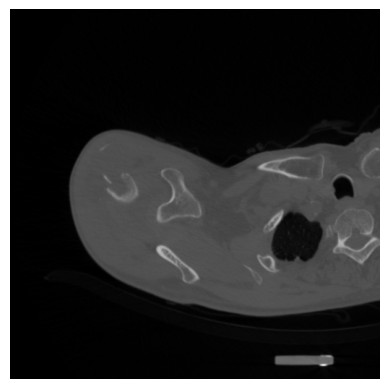

In [ ]:
!pip install pydicom

import io
from typing import Union
import requests
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqlalchemy import create_engine, text

class YoloDataset:
  query = """
    -- PostgreSQL 15

    WITH distinct_pairs AS (
      -- 1) Somente na yolo: img_id x user_id distintos (sem join)
      SELECT DISTINCT img_id, user_id
      FROM bbox.yolo
    ),
    boxes AS (
      -- 2) Pré-agrega todas as boxes por par (ordene como preferir)
      SELECT
        img_id,
        user_id,
        jsonb_agg(
          jsonb_build_object(
            'x_center', x_center,
            'y_center', y_center,
            'width',   width,
            'height',  height
          )
          ORDER BY id
        ) AS y
      FROM bbox.yolo
      GROUP BY img_id, user_id
    )
    -- 3) Monta o JSON final
    SELECT COALESCE(
      jsonb_agg(
        jsonb_build_object(
          'metadata', jsonb_build_object(
            'img_id',   i.id,
            'img_url',  i.url,
            'user_id',  u.id,
            'user_name',u.name
          ),
          'X', NULL,                              -- JSON null
          'Y', COALESCE(b.y, '[]'::jsonb)        -- array de boxes por par
        )
      )::json,
      '[]'::json
    ) AS result
    FROM distinct_pairs dp
    JOIN bbox.img   i ON i.id = dp.img_id
    JOIN bbox.users u ON u.id = dp.user_id
    LEFT JOIN boxes b
          ON b.img_id = dp.img_id
          AND b.user_id = dp.user_id;
  """
  base_url = "https://storage.googleapis.com/doctor-yolo/"
  norm_limit = 2048

  DB_HOST="34.63.204.77"
  DB_PORT="5432"
  DB_NAME="doctor_yolo"
  DB_USER="doctor_yolo"
  DB_PASSWORD=userdata.get('doctor_yolo_key')
  DB_SCHEMA="bbox"

  def __init__(self):
    print("⏳ Conectando ao banco de dados...")
    self.engine = create_engine(
      f"postgresql+psycopg2://{self.DB_USER}:{self.DB_PASSWORD}@{self.DB_HOST}:{self.DB_PORT}/{self.DB_NAME}",
      future=True
    )
    print("✅ Conectado!")
    print("\n❄️ Listando...")
    with self.engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
      conn.execute(text(f"SET search_path TO {self.DB_SCHEMA};"))
      self.data = conn.execute(text(self.query)).fetchone()[0]
    print("❇️ Pronto!")
    print("🌟 Total de registros:", len(self.data))
    print("\n🐼 Baixando pixel data (X)...")
    for row in tqdm(self.data, desc="☢ Processando imagens", unit="img"):
      row["X"] = self.getPixelData(row["metadata"]["img_url"])
    print("\n\n🎓 Pronto! ✅✅✅")

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  def show(self, idx):
    plt.imshow(self.data[idx]["X"], cmap="gray")
    plt.axis("off")
    plt.show()

  def getPixelData(self, url):
    full_url = url if url.startswith(("http://", "https://")) else self.base_url + url.lstrip("/")
    resp = requests.get(full_url, timeout=60)
    resp.raise_for_status()
    ds = pydicom.dcmread(io.BytesIO(resp.content), force=True)
    arr = ds.pixel_array  # np.ndarray
    arr = np.ascontiguousarray(arr)
    arr = (arr/max(arr.max(), self.norm_limit)).astype(np.float32)
    return arr

# Exemplo
ds = YoloDataset()
print("\n---------- EXEMPLO [0] ----------")
display(ds[0])
ds.show(0)

# Checar imagem e metadados

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import pydicom
import matplotlib.pyplot as plt
import numpy as np

def analisar_dicom():
    # === Upload do arquivo ===
    uploaded = files.upload()
    path = next(iter(uploaded))  # pega o nome do primeiro arquivo enviado

    # === Carregar o arquivo DICOM ===
    ds = pydicom.dcmread(path)

    # === Mostrar dados básicos ===
    print("Paciente:", ds.get("PatientName", "(sem nome)"))
    print("Estudo:", ds.get("StudyDescription", "(sem descrição)"))
    print("Tem dados de imagem?", "PixelData" in ds)

    # === Exibir imagem se existir ===
    if "PixelData" in ds:
        img = ds.pixel_array
        plt.imshow(img, cmap="gray")
        plt.title(ds.get("StudyDescription", "Imagem DICOM"))
        plt.axis("off")
        plt.show()
    else:
        print("\nEste arquivo DICOM não contém dados de imagem (apenas metadados).")

    # === Exibir metadados ===
    print("\n=== METADADOS DICOM ===")

    def print_metadata(ds, tab=0):
        for elem in ds:
            if elem.keyword == "PixelData":
                print(tab*"    "+f"{elem.tag} | {elem.name}: <PixelData omitido>")
            elif elem.VR != "SQ":
                print(tab*"    "+f"{elem.tag} | {elem.name}: {elem.value}")
            else:
                print(tab*"    "+f"{elem.tag} | {elem.name}: <Sequence com {len(elem.value)} itens>")
                for i, item in enumerate(elem.value):
                    print(tab*"    "+f"  -> Item #{i+1}")
                    print_metadata(item, tab+1)

    print_metadata(ds)


Series Description: VOLUME OMBRO PM

(0020,000D) | Study Instance UID: 1.2.840.55555.866261830.20200615125608077.1439

(0020,000E) | Series Instance UID: 1.3.12.2.1107.5.1.4.63825.30000020061213013538300081119

MEDICO A - PACIENTE ....

Saving 24501643 to 24501643
Paciente: TANIA REGINA GOMES PIRES
Estudo: Shoulder^OMBRO_ROTINA (Adult)
Tem dados de imagem? True


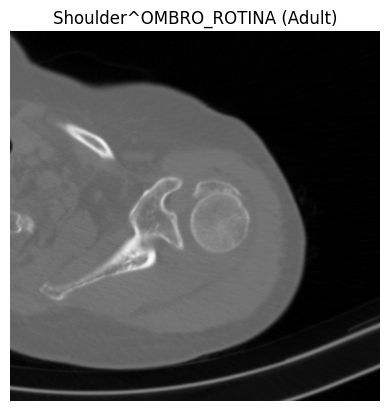


=== METADADOS DICOM ===
(0008,0005) | Specific Character Set: ISO_IR 100
(0008,0008) | Image Type: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008,0016) | SOP Class UID: 1.2.840.10008.5.1.4.1.1.2
(0008,0018) | SOP Instance UID: 1.3.12.2.1107.5.1.4.63825.30000020061213013538300081377
(0008,0020) | Study Date: 20200615
(0008,0021) | Series Date: 20200615
(0008,0022) | Acquisition Date: 20200615
(0008,0023) | Content Date: 20200615
(0008,0030) | Study Time: 131840.618000
(0008,0031) | Series Time: 132328.122000
(0008,0032) | Acquisition Time: 131957.279391
(0008,0033) | Content Time: 131957.279391
(0008,0050) | Accession Number: 3000000007936125
(0008,0060) | Modality: CT
(0008,0070) | Manufacturer: SIEMENS
(0008,0080) | Institution Name: Hospital
(0008,0081) | Institution Address: Avenida Nazare
Sao Paulo
Sao Paulo
BR
(0008,0090) | Referring Physician's Name: 
(0008,1010) | Station Name: CT63825
(0008,1030) | Study Description: Shoulder^OMBRO_ROTINA (Adult)
(0008,1032) | Procedure

In [ ]:
analisar_dicom()

Saving 24496900 to 24496900
Paciente: TANIA REGINA GOMES PIRES
Estudo: Shoulder^OMBRO_ROTINA (Adult)
Tem dados de imagem? True


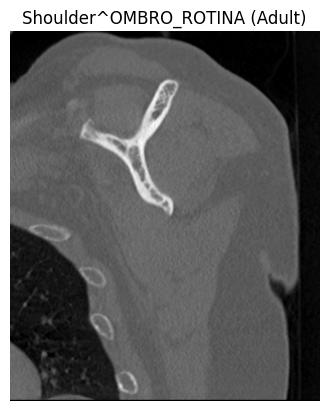


=== METADADOS DICOM ===
(0008,0005) | Specific Character Set: ISO_IR 100
(0008,0008) | Image Type: ['DERIVED', 'PRIMARY', 'AXIAL', 'CT_SOM5 MPR']
(0008,0016) | SOP Class UID: 1.2.840.10008.5.1.4.1.1.2
(0008,0018) | SOP Instance UID: 1.3.12.2.1107.5.1.4.63825.30000020061213013538300081552
(0008,0020) | Study Date: 20200615
(0008,0021) | Series Date: 20200615
(0008,0022) | Acquisition Date: 20200615
(0008,0023) | Content Date: 20200615
(0008,0030) | Study Time: 131840.618000
(0008,0031) | Series Time: 132536.046000
(0008,0032) | Acquisition Time: 131955.725386
(0008,0033) | Content Time: 131955.725386
(0008,0050) | Accession Number: 3000000007936125
(0008,0060) | Modality: CT
(0008,0070) | Manufacturer: SIEMENS
(0008,0080) | Institution Name: Hospital
(0008,0081) | Institution Address: Avenida Nazare
Sao Paulo
Sao Paulo
BR
(0008,0090) | Referring Physician's Name: 
(0008,1010) | Station Name: CT63825
(0008,1030) | Study Description: Shoulder^OMBRO_ROTINA (Adult)
(0008,1032) | Procedure 

In [ ]:
analisar_dicom()